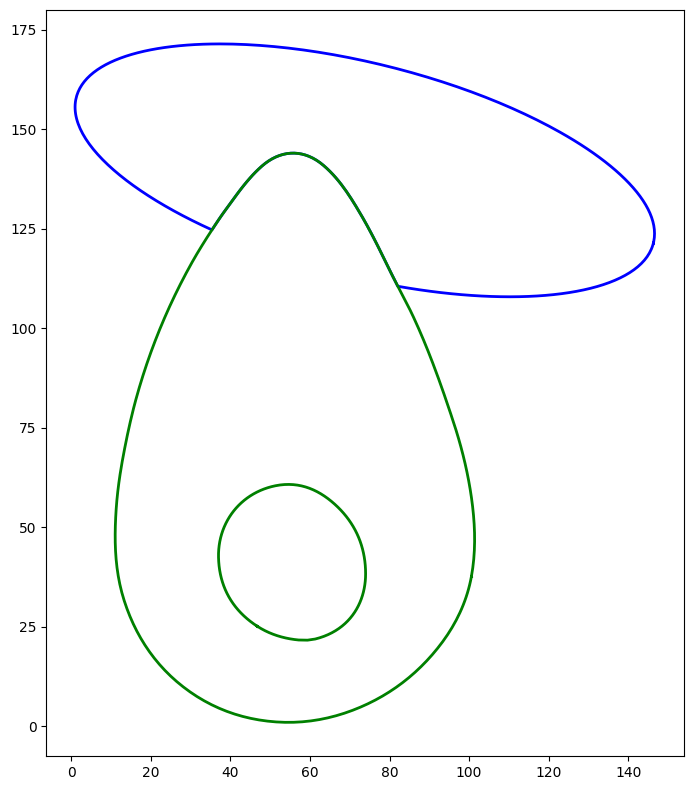

In [434]:
import numpy as np
import matplotlib.pyplot as plt
import math

# Function to read CSV file
def read_csv(csv_path):
    np_path_XYs = np.genfromtxt(csv_path, delimiter=',')
    path_XYs = []
    for i in np.unique(np_path_XYs[:, 0]):
        npXYs = np_path_XYs[np_path_XYs[:, 0] == i][:, 1:]
        XYs = []
        for j in np.unique(npXYs[:, 0]):
            XY = npXYs[npXYs[:, 0] == j][:, 1:]
            XYs.append(XY)
        path_XYs.append(XYs)
    return path_XYs

# Function to visualize polylines
def plot(paths_XYs):
    fig, ax = plt.subplots(tight_layout=True, figsize=(8, 8))
    colours = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
    for i, XYs in enumerate(paths_XYs):
        c = colours[i % len(colours)]
        for XY in XYs:
            ax.plot(XY[:, 0], XY[:, 1], c=c, linewidth=2)
    ax.set_aspect('equal')
    # plt.legend(handles, labels, title="Path Indices")
    plt.show()

# Main script
csv_path = './problems/occlusion1.csv'
path_XYs = read_csv(csv_path)
plot(path_XYs)

In [435]:
def is_close_path(XY, tolerance):
    """
    Checks if the start and end points of a path are within a specified tolerance.

    Args:
        XY (np.array): An Nx2 array representing the path, where N is the number of points.
        tolerance (float): Maximum allowed distance between the start and end points to be considered close.

    Returns:
        bool: True if the start and end points are close, False otherwise.
    """
    start_point = XY[0]
    end_point = XY[-1]
    return np.linalg.norm(start_point - end_point) <= tolerance

In [436]:
def is_close(point1, point2, tolerance):
    """
    Checks if two points are within a specified tolerance.

    Args:
        point1 (np.array): Coordinates of the first point (x1, y1).
        point2 (np.array): Coordinates of the second point (x2, y2).
        tolerance (float): Maximum allowed distance between the points to be considered close.

    Returns:
        bool: True if the points are close, False otherwise.
    """
    return np.linalg.norm(point1 - point2) <= tolerance

def complete_shape(XY, tolerance):
    """
    Ensures the shape is properly closed by appending the start point to the end if they are not close.

    Args:
        XY (np.array): An Nx2 array representing the path, where N is the number of points.
        tolerance (float): Maximum allowed distance to consider the shape as closed.

    Returns:
        np.array: The completed shape.
    """
    if not is_close(XY[0], XY[-1], tolerance):
        XY = np.vstack([XY, XY[0]])
    return XY

In [437]:
def is_circle(XY, tolerance):
    """
    Checks if a given path forms a circle within a specified tolerance.

    Args:
        XY (np.array): An Nx2 array representing the path, where N is the number of points.
        tolerance (float): Maximum allowed deviation from a perfect circle to be considered a circle.

    Returns:
        bool: True if the path forms a circle, False otherwise.
    """
    # Calculate the centroid of the path
    centroid = np.mean(XY, axis=0)

    # Calculate the distances from the centroid to each point in the path
    distances = np.linalg.norm(XY - centroid, axis=1)

    # Calculate the mean distance (this will be the radius)
    mean_distance = np.mean(distances)

    # Check if all distances are within the tolerance
    return np.all(np.abs(distances - mean_distance) <= tolerance)


def regularize_circle(XY, num_points=100):
    """
    Replaces a circular path with a regularized one.

    Args:
        XY (np.array): An Nx2 array representing the circular path, where N is the number of points.
        num_points (int): Number of points in the regularized circle.

    Returns:
        np.array: An num_pointsx2 array representing the regularized circle.
    """
    # Calculate the centroid of the path
    centroid = np.mean(XY, axis=0)

    # Calculate the distances from the centroid to each point in the path
    distances = np.linalg.norm(XY - centroid, axis=1)

    # Calculate the mean distance (this will be the radius)
    radius = np.mean(distances)

    # Generate angles for the regularized circle
    angles = np.linspace(0, 2 * np.pi, num_points, endpoint=False)

    # Calculate the x and y coordinates of the regularized circle
    x = centroid[0] + radius * np.cos(angles)
    y = centroid[1] + radius * np.sin(angles)

    # Return the regularized circle
    return np.column_stack((x, y))

In [439]:
def is_star(XY, far_tolerance=2, near_tolerance=1, min_points=5, max_points=6):
    # Calculate the centroid
    centroid = np.mean(XY, axis=0)

    # Find the farthest point
    farthest_point = max(XY, key=lambda p: np.linalg.norm(p - centroid))

    # Find all points within the far tolerance
    far_points = [
        p
        for p in XY
        if abs(np.linalg.norm(p - centroid) - np.linalg.norm(farthest_point - centroid))
        < far_tolerance
    ]

    # Find the closest point
    closest_point = min(XY, key=lambda p: np.linalg.norm(p - centroid))

    # Find all points within the near tolerance
    near_points = [
        p
        for p in XY
        if abs(np.linalg.norm(p - centroid) - np.linalg.norm(closest_point - centroid))
        < near_tolerance
    ]

    # Check the number of far and near points
    return (min_points <= len(far_points) <= max_points) and (
        min_points <= len(near_points) <= max_points
    )
    # return (len(far_points), len(near_points))


def regularize_star(XY, far_tolerance=2, near_tolerance=1, min_points=5, max_points=6):
    centroid = np.mean(XY, axis=0)

    # Find the farthest point
    farthest_point = max(XY, key=lambda p: np.linalg.norm(p - centroid))

    # Find all points within the far tolerance
    far_points = [
        p
        for p in XY
        if abs(np.linalg.norm(p - centroid) - np.linalg.norm(farthest_point - centroid))
        < far_tolerance
    ]

    # Find the closest point
    closest_point = min(XY, key=lambda p: np.linalg.norm(p - centroid))

    # Find all points within the near tolerance
    near_points = [
        p
        for p in XY
        if abs(np.linalg.norm(p - centroid) - np.linalg.norm(closest_point - centroid))
        < near_tolerance
    ]

    # Calculate the average distance of far and near points
    far_radius = np.mean([np.linalg.norm(p - centroid) for p in far_points])
    near_radius = np.mean([np.linalg.norm(p - centroid) for p in near_points])

    new_points = []
    for i in range(len(far_points)):
        angle = 2 * np.pi * i / len(far_points)
        far_x = centroid[0] + far_radius * np.cos(angle)
        far_y = centroid[1] + far_radius * np.sin(angle)
        new_points.append([far_x, far_y])

        near_x = centroid[0] + near_radius * np.cos(angle + np.pi / len(far_points))
        near_y = centroid[1] + near_radius * np.sin(angle + np.pi / len(far_points))
        new_points.append([near_x, near_y])

    # Add an additional point to complete the star shape
    new_points.append(new_points[0])  # Close the star shape

    return np.array(new_points)

In [440]:
def find_rectangle_vertices(XY):
    # Calculate the centroid
    centroid = np.mean(XY, axis=0)

    # Divide points into 4 quadrants
    quadrants = [
        XY[(XY[:, 0] < centroid[0]) & (XY[:, 1] > centroid[1])],  # top-left
        XY[(XY[:, 0] > centroid[0]) & (XY[:, 1] > centroid[1])],  # top-right
        XY[(XY[:, 0] > centroid[0]) & (XY[:, 1] < centroid[1])],  # bottom-right
        XY[(XY[:, 0] < centroid[0]) & (XY[:, 1] < centroid[1])],  # bottom-left
    ]

    # Find farthest point from each quadrant
    vertices = [
        quadrant[np.argmax(np.linalg.norm(quadrant - centroid, axis=1))]
        for quadrant in quadrants
    ]

    return vertices


def distance_between_vertices(vertices, min_distance):
    distances = []
    for i in range(len(vertices)):
        for j in range(i + 1, len(vertices)):
            distance = np.linalg.norm(vertices[i] - vertices[j])
            distances.append(distance)

    if np.min(distances) < min_distance:
        return False
    else:
        return True


def is_rectangle(XY, tolerance=5, min_distance=10):
    vertices = find_rectangle_vertices(XY)
    centroid = np.mean(XY, axis=0)

    # Calculate angles between adjacent vertices
    angles = []
    for i in range(len(vertices)):
        p1 = vertices[i]
        p2 = vertices[(i + 1) % len(vertices)]
        p3 = vertices[(i + 2) % len(vertices)]

        v1 = p2 - p1
        v2 = p3 - p2
        dot_product = np.dot(v1, v2)
        magnitude_product = np.linalg.norm(v1) * np.linalg.norm(v2)
        angle = np.arccos(dot_product / magnitude_product) * 180 / np.pi

        angles.append(angle)

    # Check if vertices are far apart
    if not distance_between_vertices(vertices, min_distance):
        return False
    # Check if all angles are close to 90 degrees within the tolerance
    return all(abs(angle - 90) < tolerance for angle in angles)


def regularize_rectangle(XY):
    vertices = find_rectangle_vertices(XY)
    centroid = np.mean(XY, axis=0)

    # Sort vertices clockwise or counterclockwise
    vertices = sorted(
        vertices, key=lambda p: math.atan2(p[1] - centroid[1], p[0] - centroid[0])
    )

    # Create a new path with straight lines between vertices
    new_path = np.array(
        [
            *vertices[0],
            *vertices[1],
            *vertices[2],
            *vertices[3],
            *vertices[0],  # Close the rectangle
        ]
    ).reshape(-1, 2)

    return new_path

In [442]:
def is_straight_line(XY, tolerance=0.01):
    """
    Checks if a set of points forms a straight line within a given tolerance
    using curvature.

    Args:
        XY: A numpy array of shape (n, 2) representing n points (x, y).
        tolerance: The maximum allowed curvature for the line to be
                   considered straight.

    Returns:
        True if the points form a straight line within the tolerance,
        False otherwise.
    """

    # Handle cases with less than 3 points
    if len(XY) < 3:
        return True

    # Calculate first-order differences
    dx = np.diff(XY[:, 0])
    dy = np.diff(XY[:, 1])

    # Calculate second-order differences
    d2x = np.diff(dx)
    d2y = np.diff(dy)

    # Calculate curvature at each point
    curvature = np.abs(d2y * dx[:-1] - d2x * dy[:-1]) / (dx[:-1]**2 + dy[:-1]**2)**1.5

    # Check if the maximum curvature is within the tolerance
    return np.all(curvature <= tolerance)

def regularize_straight_line(XY):
    # Calculate the start and end points
    start_point = XY[0]
    end_point = XY[-1]

    # Calculate the slope of the line
    slope = (end_point[1] - start_point[1]) / (end_point[0] - start_point[0])

    # Calculate the new x-coordinates
    new_x = np.linspace(start_point[0], end_point[0], len(XY))

    # Calculate the new y-coordinates using the slope
    new_y = slope * (new_x - start_point[0]) + start_point[1]

    # Return the regularized straight line
    return np.column_stack((new_x, new_y))

In [443]:
def is_arc(XY, tolerance=0.1, min_points=5, min_angle=5):
    """
    Checks if a set of points forms an arc of a circle within a given tolerance.

    Args:
        XY: A numpy array of shape (n, 2) representing n points (x, y).
        tolerance: The maximum allowed deviation from a perfect circle
                   (as a fraction of the radius).
        min_points: The minimum number of points required to be considered an arc.
        min_angle: The minimum central angle of the arc in degrees.

    Returns:
        True if the points form an arc within the tolerance, False otherwise.
    """

    if len(XY) < min_points:
        return False

    center, radius = hyper_fit_circle(XY)
    distances = np.linalg.norm(XY - center, axis=1)
    is_circular = np.all(np.abs(distances - radius) <= tolerance * radius)
    if not is_circular:
        return False

    # Calculate vectors and angles
    vectors = XY - center
    angles = np.arctan2(vectors[:, 1], vectors[:, 0])

    # Sort points by angle
    sorted_indices = np.argsort(angles)
    sorted_vectors = vectors[sorted_indices]

    # Initialize angle_diffs
    angle_diffs = np.empty_like(sorted_vectors[:, 0])

    # Calculate angle differences using cross product for direction
    for i in range(len(sorted_vectors) - 1):
        v1 = sorted_vectors[i]
        v2 = sorted_vectors[i + 1]
        angle_diff = np.arctan2(v2[1], v2[0]) - np.arctan2(v1[1], v1[0])

        # Adjust angle difference based on cross product
        cross_product_z = np.cross(v1, v2)
        if cross_product_z < 0:  # Need to adjust for clockwise direction
            angle_diff += 2 * np.pi if angle_diff < 0 else -2 * np.pi

        angle_diffs[i] = angle_diff

    # Last angle difference needs special handling
    v1 = sorted_vectors[-1]
    v2 = sorted_vectors[0]
    angle_diff = np.arctan2(v2[1], v2[0]) - np.arctan2(v1[1], v1[0])
    cross_product_z = np.cross(v1, v2)
    if cross_product_z < 0:
        angle_diff += 2 * np.pi if angle_diff < 0 else -2 * np.pi
    angle_diffs[-1] = angle_diff

    central_angle = np.abs(np.sum(angle_diffs)) * 180 / np.pi
    return central_angle >= min_angle


def hyper_fit_circle(XY):
    """Fits a circle to a set of points using the Hyperaccurate Circle Fit.

    This implementation is based on the algorithm described in:
    "Circle Fit (Hyper Fit)" by Nikolai Chernov
    http://people.cas.uab.edu/~mosya/cl/

    Args:
        XY: A numpy array of shape (n, 2) representing n points (x, y).

    Returns:
        A tuple (center, radius) containing the circle's center and radius.
    """
    n = len(XY)
    x = XY[:, 0]
    y = XY[:, 1]

    x_m = np.mean(x)
    y_m = np.mean(y)

    u = x - x_m
    v = y - y_m

    Suv  = np.sum(u * v)
    Suu  = np.sum(u ** 2)
    Svv  = np.sum(v ** 2)
    Suuv = np.sum(u ** 2 * v)
    Suvv = np.sum(u * v ** 2)
    Suuu = np.sum(u ** 3)
    Svvv = np.sum(v ** 3)

    A = np.array([
        [Suu, Suv],
        [Suv, Svv]
    ])
    B = np.array([Suuu + Suvv, Suuv + Svvv]) / 2.0
    uc, vc = np.linalg.solve(A, B)

    xc = x_m + uc
    yc = y_m + vc

    Ri = np.sqrt((x - xc) ** 2 + (y - yc) ** 2)
    radius = np.mean(Ri)

    return np.array([xc, yc]), radius

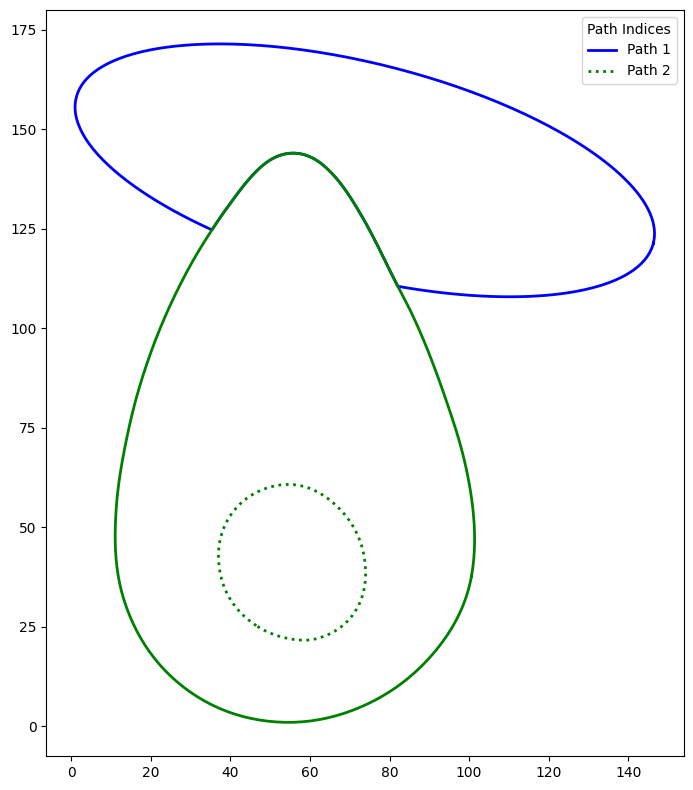

In [444]:
def plot_new(paths_XYs):
    fig, ax = plt.subplots(tight_layout=True, figsize=(8, 8))
    colours = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

    # Create empty handles and labels lists for the legend
    handles = []
    labels = []

    for i, XYs in enumerate(paths_XYs):
        c = colours[i % len(colours)]
        for XY in XYs:
            # Check if the line is straight
            if is_close_path(XY, tolerance=1):
                XY = complete_shape(XY, tolerance=0.1)
                if is_circle(XY, tolerance=6):
                    line, = ax.plot(XY[:, 0], XY[:, 1], c=c, linewidth=2, linestyle='dotted')
                elif is_circle(XY, tolerance=15):
                    line, = ax.plot(XY[:, 0], XY[:, 1], c=c, linewidth=2, linestyle='dashed')
                elif is_star(XY):
                    line, = ax.plot(XY[:, 0], XY[:, 1], c=c, linewidth=2, linestyle='dashdot')
                else:
                    line, = ax.plot(XY[:, 0], XY[:, 1], c=c, linewidth=2)
            else:
                if is_straight_line(XY, tolerance=0.01):
                    line, = ax.plot(XY[:, 0], XY[:, 1], c=c, linewidth=2, linestyle='dotted')
                elif is_arc(XY, tolerance=0.1, min_points=5, min_angle=5):
                    line, = ax.plot(XY[:, 0], XY[:, 1], c=c, linewidth=2, linestyle='dashdot')
                else:
                    line, = ax.plot(XY[:, 0], XY[:, 1], c=c, linewidth=2, linestyle='--')

        # Append the line handle and label for the legend
        handles.append(line)
        labels.append(f"Path {i+1}")  # Add 1 to index for 1-based indexing

    ax.set_aspect('equal')

    # Add the legend with path indices
    plt.legend(handles, labels, title="Path Indices")

    plt.show()

plot_new(path_XYs)

In [445]:
# Analyze and describe shapes
for i, XYs in enumerate(path_XYs):
    for j, XY in enumerate(XYs):
        if is_close_path(XY, tolerance=1):
            XY = complete_shape(XY, tolerance=0.1)
            if is_circle(XY, tolerance=6):
                print(f"Polyline {i+1}, Segment {j+1}: Circle")
            elif is_circle(XY, tolerance=15):
                print(f"Polyline {i+1}, Segment {j+1}: Rectangle")
            # elif is_circle(XY, tolerance=40):
                # print(f"Polyline {i+1}, Segment {j+1}: Star")
            elif is_circle(XY, tolerance=40):
                print(f"Polyline {i+1}, Segment {j+1}: Star")
            else:
                print(f"Polyline {i+1}, Segment {j+1}: Irregular Closed Shape")
        else:
            if is_straight_line(XY, tolerance=0.01):
                print(f"Polyline {i+1}, Segment {j+1}: Straight Line")
            elif is_arc(XY, tolerance=0.1, min_points=5, min_angle=5):
                print(f"Polyline {i+1}, Segment {j+1}: Arc")
            else:
                print(f"Polyline {i+1}, Segment {j+1}: Irregular Open Shape")


Polyline 1, Segment 1: Irregular Closed Shape
Polyline 2, Segment 1: Star
Polyline 2, Segment 2: Circle


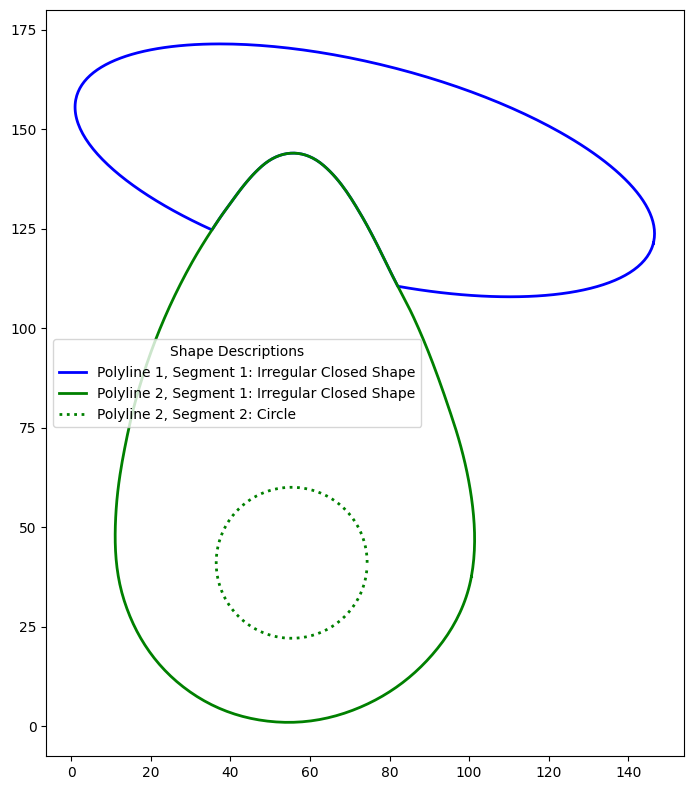

In [446]:
def plot_new(paths_XYs):
    fig, ax = plt.subplots(tight_layout=True, figsize=(8, 8))
    colours = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

    handles = []
    labels = []

    for i, XYs in enumerate(paths_XYs):
        c = colours[i % len(colours)]
        for j, XY in enumerate(XYs):
            if is_close_path(XY, tolerance=1):
                XY = complete_shape(XY, tolerance=0.1)
                if is_circle(XY, tolerance=6):
                    XY = regularize_circle(XY, num_points=150)
                    line, = ax.plot(XY[:, 0], XY[:, 1], c=c, linewidth=2, linestyle='dotted')
                    label = f"Polyline {i+1}, Segment {j+1}: Circle"
                elif is_rectangle(XY, tolerance=3):
                    XY = regularize_rectangle(XY)
                    line, = ax.plot(XY[:, 0], XY[:, 1], c=c, linewidth=2, linestyle='dashed')
                    label = f"Polyline {i+1}, Segment {j+1}: Rectangle"
                elif is_star(XY):
                    XY = regularize_star(XY)
                    line, = ax.plot(XY[:, 0], XY[:, 1], c=c, linewidth=2, linestyle='dashdot')
                    label = f"Polyline {i+1}, Segment {j+1}: Star"
                else:
                    line, = ax.plot(XY[:, 0], XY[:, 1], c=c, linewidth=2)
                    label = f"Polyline {i+1}, Segment {j+1}: Irregular Closed Shape"
            else:
                if is_straight_line(XY, tolerance=0.01):
                    XY = regularize_straight_line(XY)
                    line, = ax.plot(XY[:, 0], XY[:, 1], c=c, linewidth=2, linestyle='dotted')
                    label = f"Polyline {i+1}, Segment {j+1}: Straight Line"
                elif is_arc(XY, tolerance=0.1, min_points=5, min_angle=5):
                    line, = ax.plot(XY[:, 0], XY[:, 1], c=c, linewidth=2, linestyle='dashdot')
                    label = f"Polyline {i+1}, Segment {j+1}: Arc"
                else:
                    line, = ax.plot(XY[:, 0], XY[:, 1], c=c, linewidth=2, linestyle='--')
                    label = f"Polyline {i+1}, Segment {j+1}: Irregular Open Shape"

            handles.append(line)
            labels.append(label)

    ax.set_aspect('equal')
    plt.legend(handles, labels, title="Shape Descriptions")
    plt.show()

plot_new(path_XYs)

In [447]:
import numpy as np
from sklearn.decomposition import PCA


def centralize_and_normalize(XY):
    # Centralizing the polyline
    centroid = np.mean(XY, axis=0)
    XY_centered = XY - centroid

    # Normalizing the polyline to fit within a unit circle
    max_distance = np.max(np.linalg.norm(XY_centered, axis=1))
    XY_normalized = XY_centered / max_distance

    return XY_normalized

def reflect_points(XY, axis="x"):
    if axis == "x":
        return np.array([XY[:, 0], -XY[:, 1]]).T
    elif axis == "y":
        return np.array([-XY[:, 0], XY[:, 1]]).T
    elif axis == "xy":
        return np.array([-XY[:, 0], -XY[:, 1]]).T
    else:
        raise ValueError("Invalid axis for reflection. Use 'x', 'y', or 'xy'.")

def compute_symmetry(XY, tolerance=0.1):
    # XY = centralize_and_normalize(XY)
    symmetries_found = []

    # Reflection tests
    axes = ["x", "y", "xy"]
    for axis in axes:
        XY_reflected = reflect_points(XY, axis)
        distances = np.linalg.norm(XY - XY_reflected, axis=1)

        if np.all(distances < tolerance):
            symmetries_found.append(axis)

    if symmetries_found:
        print(f"Symmetry found along the {', '.join(symmetries_found)}-axis/axes with tolerance {tolerance}.")
        return True
    else:
        print("No symmetry found.")
        return False


tolerance = 0.1
for i, XYs in enumerate(path_XYs):
    for j, XY in enumerate(XYs):
        if compute_symmetry(XY, 2):
            print(f"The polyline {i},{j} is symmetric within the tolerance.")
        else:
            print(f"The polyline {i},{j} is not symmetric within the tolerance.")

No symmetry found.
The polyline 0,0 is not symmetric within the tolerance.
No symmetry found.
The polyline 1,0 is not symmetric within the tolerance.
No symmetry found.
The polyline 1,1 is not symmetric within the tolerance.


In [449]:
def check_symmetry(path, tolerance_loss=120):
    """
    Check if a path has symmetry along the x-axis or y-axis.

    Parameters:
    path (np.array): An Nx2 array representing the path, where N is the number of points.
    tolerance_loss (float): The tolerance loss for symmetry checking. Default is 1e-2.

    Returns:
    symmetry (str): 'x-axis', 'y-axis', 'both', or 'none' depending on the symmetry of the path.
    """
    x_loss, y_loss = calculate_symmetry_loss(path)

    if x_loss < tolerance_loss and y_loss < tolerance_loss:
        return 'both'
    elif x_loss < tolerance_loss:
        return 'x-axis'
    elif y_loss < tolerance_loss:
        return 'y-axis'
    else:
        return 'none'

def calculate_symmetry_loss(path):
    # Mirror the path along the x-axis and y-axis
    x_mirrored = np.array([[-x, y] for x, y in path])
    y_mirrored = np.array([[x, -y] for x, y in path])

    # Calculate the symmetry loss along the x-axis
    x_loss = np.mean(np.linalg.norm(path - x_mirrored, axis=1))

    # Calculate the symmetry loss along the y-axis
    y_loss = np.mean(np.linalg.norm(path - y_mirrored, axis=1))

    return x_loss, y_loss

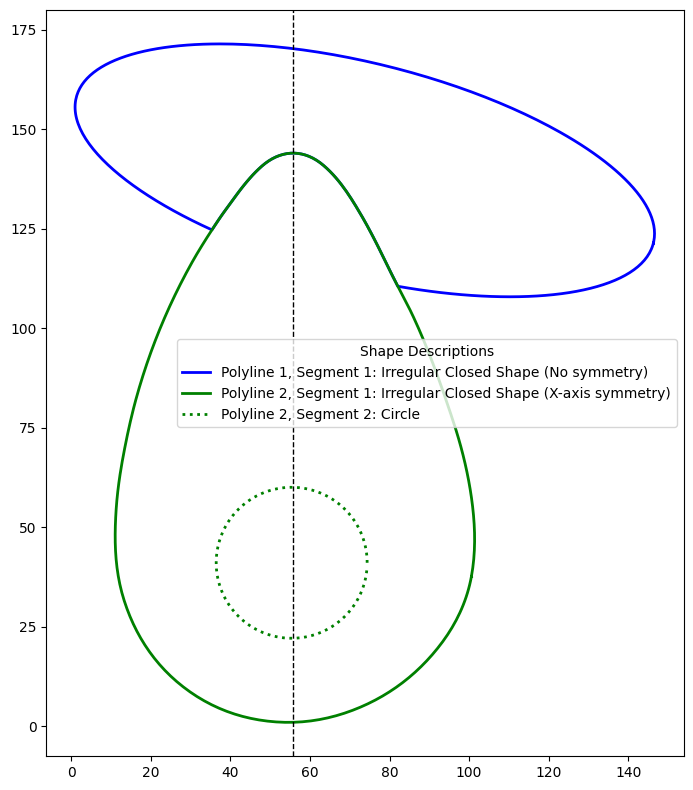

In [451]:
def plot_new(paths_XYs):
    fig, ax = plt.subplots(tight_layout=True, figsize=(8, 8))
    colours = ["b", "g", "r", "c", "m", "y", "k"]

    handles = []
    labels = []

    for i, XYs in enumerate(paths_XYs):
        c = colours[i % len(colours)]
        for j, XY in enumerate(XYs):
            if is_close_path(XY, tolerance=1):
                XY = complete_shape(XY, tolerance=0.1)
                if is_circle(XY, tolerance=6):
                    XY = regularize_circle(XY, num_points=150)
                    (line,) = ax.plot(
                        XY[:, 0], XY[:, 1], c=c, linewidth=2, linestyle="dotted"
                    )
                    label = f"Polyline {i+1}, Segment {j+1}: Circle"
                elif is_rectangle(XY, tolerance=3):
                    XY = regularize_rectangle(XY)
                    (line,) = ax.plot(
                        XY[:, 0], XY[:, 1], c=c, linewidth=2, linestyle="dashed"
                    )
                    label = f"Polyline {i+1}, Segment {j+1}: Rectangle"
                elif is_star(XY):
                    XY = regularize_star(XY)
                    (line,) = ax.plot(
                        XY[:, 0], XY[:, 1], c=c, linewidth=2, linestyle="dashdot"
                    )
                    label = f"Polyline {i+1}, Segment {j+1}: Star"
                else:
                    symmetry = check_symmetry(XY)
                    if symmetry == "x-axis":
                        (line,) = ax.plot(
                            XY[:, 0], XY[:, 1], c=c, linewidth=2, linestyle="solid"
                        )
                        label = f"Polyline {i+1}, Segment {j+1}: Irregular Closed Shape (X-axis symmetry)"
                        ax.axvline(
                            x=np.mean(XY[:, 0]), color="k", linestyle="--", linewidth=1
                        )
                    elif symmetry == "y-axis":
                        (line,) = ax.plot(
                            XY[:, 0], XY[:, 1], c=c, linewidth=2, linestyle="solid"
                        )
                        label = f"Polyline {i+1}, Segment {j+1}: Irregular Closed Shape (Y-axis symmetry)"
                        ax.axhline(
                            y=np.mean(XY[:, 1]), color="k", linestyle="--", linewidth=1
                        )
                    elif symmetry == "both":
                        (line,) = ax.plot(
                            XY[:, 0], XY[:, 1], c=c, linewidth=2, linestyle="solid"
                        )
                        label = f"Polyline {i+1}, Segment {j+1}: Irregular Closed Shape (Both X and Y-axis symmetry)"
                        ax.axvline(
                            x=np.mean(XY[:, 0]), color="k", linestyle="--", linewidth=1
                        )
                        ax.axhline(
                            y=np.mean(XY[:, 1]), color="k", linestyle="--", linewidth=1
                        )
                    else:
                        (line,) = ax.plot(XY[:, 0], XY[:, 1], c=c, linewidth=2)
                        label = f"Polyline {i+1}, Segment {j+1}: Irregular Closed Shape (No symmetry)"
            else:
                if is_straight_line(XY, tolerance=0.01):
                    XY = regularize_straight_line(XY)
                    (line,) = ax.plot(
                        XY[:, 0], XY[:, 1], c=c, linewidth=2, linestyle="dotted"
                    )
                    label = f"Polyline {i+1}, Segment {j+1}: Straight Line"
                elif is_arc(XY, tolerance=0.1, min_points=5, min_angle=5):
                    (line,) = ax.plot(
                        XY[:, 0], XY[:, 1], c=c, linewidth=2, linestyle="dashdot"
                    )
                    label = f"Polyline {i+1}, Segment {j+1}: Arc"
                else:
                    (line,) = ax.plot(
                        XY[:, 0], XY[:, 1], c=c, linewidth=2, linestyle="--"
                    )
                    label = f"Polyline {i+1}, Segment {j+1}: Irregular Open Shape"

            handles.append(line)
            labels.append(label)

    ax.set_aspect("equal")
    plt.legend(handles, labels, title="Shape Descriptions")
    plt.show()


plot_new(path_XYs)